In [360]:
import numpy as np
from sklearn.neural_network import BernoulliRBM
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Restricted Boltzmann Machine (SKlearn version)

Let's build an RBM model using SciKitLearn's implementation of RBMs.  We'll fit a binarized version of our MovieLens rating data, split into training and test.  

The RBM model consists of a "visible" layer (the variables we want to model -- here, X[j,i], the binary "user j liked movie i" indicator), and a "hidden" layer, which are the latent variables used to model correlations in the distribution of X.  So, for example, if $H_1=1$, it might cause certain movies to be more likely to be liked, and others to be less likely.  We never observe the $H$ values, so to use this model for prediction, observing some $X$ values lets us infer the hidden $H$ values for that user, which lets us predict the unobserved $X$ values.

First, let's construct the data set we'll use:

In [633]:
# names of 500 movies to be rated:
with open('mlens-small/top-names.txt') as f: names = f.read().split('\n')
    
# ratings = int(2000 x 500) ratings of 500 movies by 2000 people; -1 = not rated
ratings = np.loadtxt('mlens-small/top-ratings-missing.txt')
nUsers,nMovies = ratings.shape

In [634]:
X = (ratings >= 7).astype(int);   # did each user like the movie?  (binary)
# (use any threshold you like, but "7+" might be "worth recommending"?)

In [682]:
# Let's split into training & test:
np.random.seed(0)
pi = np.random.permutation(nUsers)
iTr,iTe = pi[:int(nUsers*.9)], pi[int(nUsers*.9):]
Xtr,Xte = X[iTr,:],X[iTe,:]

In [678]:
Xtr.shape

(1600, 500)

For the test points, we want to conceal some of the values.  We will use the non-missing values of each X[j,:] to estimate the missing entries (which we indicate with "-1"):

In [683]:
# for a prediction task, censor some entries in X[iTe,:]:
Xte_missing = np.copy(Xte)
Xte_missing[ np.random.random_sample(Xte.shape)<=.3 ] = -1  # discard 30% of observations

# Now, we can measure the likelihood of Xte,
# or predict Xte given Xte_missing

### RBM model

We can declare an RBM model and then fit it to our training data pretty easily:

In [671]:
# rbm = BernoulliRBM(n_components=16, learning_rate=0.1, batch_size=10, n_iter=100, verbose=0, random_state=0)
rbm = BernoulliRBM(random_state=0, verbose=0)
rbm.learning_rate = 0.06
rbm.n_iter = 10
rbm.n_components = 100


In [672]:
rbm.fit(Xtr)

BernoulliRBM(learning_rate=0.06, n_components=100, random_state=0)

### Measuring likelihood:

The RBM is a large, undirected model, and so not a normalized probability distribution.  To calculate the actual log-likelihood of a data set, we would need to evaluate the (log) normalization constant $\ln Z$.  In general, this can be quite computationally difficult, and so we either subsitute an *estimate* of $\ln Z$, or a surrogate (approximation) to the likelihood function itself.

A common substitute for RBMs is the *pseudo-likelihood* of the model, most typically a stochastic (Monte Carlo) estimate of the pseudo-likelihood.  In the scikit version, this is called "score_samples":

In [593]:
print(rbm.score_samples(Xte).mean())

-249.8931464135897


If we train with a more complex class of distributions (say, with more hidden variables), we can potentially fit the data better (although we may also begin to overfit!):

In [684]:
rbm = BernoulliRBM(n_components=512, learning_rate=0.006, batch_size=10, n_iter=200, verbose=0, random_state=0)
rbm.fit(Xtr)
print(rbm.score_samples(Xte).mean())

-240.0737634274568


### Predicting missing data:

A basic RBM is not a classic supervised predictor, in which we measure "x" and predict "y" -- instead, it is a generative model, in which we learn a distribution $p(x)$.  We can, however, use this model to make predictions, in a fairly flexible way.  Suppose we observe some values of the vector $x$, but not others.  We can then use the conditional distribution $p(X_{unobs} | X_{obs}=x_{obs})$ to predict the unobserved variables given the value of the observed ones.  Typically, we would like to compute the most likely value of $X_{unobs}$ (the maximum a posteriori or MAP estimate), or their expected value (the mean estimate).  Here, let's do something a bit simpler and just draw a sample from $p(X_{unobs} | X_{obs}=x_{obs})$, which we can do (approximately) using Gibbs sampling:

In [665]:
def sample_missing(rbm, Xobs, nIter=10):
    Xhat = np.copy(Xobs)
    Xhat[Xhat<0] = .5         # should probably initialize this to random 0/1s

    # Do Gibbs sampling but lock the observed vars to their known values:
    for it in range(nIter):
        Xhat=rbm.gibbs(Xhat)               # resample visible layer
        Xhat[Xobs >= 0] = Xobs[Xobs >= 0]  # keep observed values fixed
    return Xhat

def sample_missing_mean(rbm, Xobs, nIter=10):
    Xhat = np.copy(Xobs)
    print(np.where(Xhat[Xhat <0]))
    Xhat[Xhat<0] = np.random.random_sample()<=.5        # should probably initialize this to random 0/1s
    # Do Gibbs sampling but lock the observed vars to their known values:
    Xhat_all = []
    xtemp = np.zeros(Xobs.shape)
    for it in range(nIter):
        Xhat=rbm.gibbs(Xhat)               # resample visible layer
        Xhat[Xobs >= 0] = Xobs[Xobs >= 0]  # keep observed values fixed
        Xhat_all.append(Xhat)
    for i in Xhat_all:
        xtemp += i
    xtemp = (xtemp > 0.5).astype(int);
    Xhat[np.where(xtemp > 0.5) ] = 1
    return Xhat

In [685]:
Xte_hat1 = sample_missing(rbm,Xte_missing, nIter=100);

print('Error rate:', np.mean( (Xte_hat1!=Xte)[Xte_missing<0] ) )


Error rate: 0.28567631325381265


In [667]:
roc_auc = metrics.roc_auc_score(Xte.reshape(-1,1),Xte_hat1.reshape(-1,1))
recall  = metrics.recall_score(Xte.reshape(-1,1),Xte_hat1.reshape(-1,1))
auc = metrics.accuracy_score(Xte.reshape(-1,1),Xte_hat1.reshape(-1,1))
ap = metrics.precision_score(Xte.reshape(-1,1),Xte_hat1.reshape(-1,1))
mse = metrics.mean_squared_error(Xte.reshape(-1,1),Xte_hat1.reshape(-1,1))
roc_auc, auc, recall, ap, mse

(0.9081605784472764, 0.914006, 0.8887876861033299, 0.868056798854176, 0.085994)

In [686]:
ratio = []
for i in trange(1,10):
    temp = i * .1
    np.random.seed(0)
    pi = np.random.permutation(nUsers)
    iTr,iTe = pi[:int(nUsers*.7)], pi[int(nUsers*.7):]
    Xtr,Xte = X[iTr,:],X[iTe,:]
    Xte_missing = np.copy(Xte)
    Xte_missing[ np.random.random_sample(Xte.shape)<= 0.3 ] = -1
    rbm = BernoulliRBM(n_components=512, learning_rate=0.006, batch_size=10, n_iter=200, verbose=0, random_state=0)
    rbm.fit(Xtr)
    Xte_hat1 = sample_missing(rbm,Xte_missing, nIter=100)
    ratio.append(Xte_hat1)
ratio

100%|██████████| 9/9 [17:10<00:00, 114.48s/it]


[array([[ True, False,  True, ...,  True, False, False],
        [ True, False,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True, False, False],
        [False,  True, False, ...,  True,  True, False],
        [False,  True, False, ..., False, False, False]]),
 array([[ True,  True,  True, ...,  True, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True, False, False],
        [False,  True, False, ...,  True,  True, False],
        [False,  True, False, ..., False, False, False]]),
 array([[ True, False,  True, ...,  True, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True, False, False],
        [False,  True, False, ..., False,  Tr

In [687]:
[np.mean( (i!=Xte)[Xte_missing<0] ) for i in ratio]

[0.030816059010420137,
 0.06266154176572093,
 0.0944514800743555,
 0.1266746650669866,
 0.16145289460626394,
 0.19704947899309028,
 0.23722292578521334,
 0.2843949728572804,
 0.3497744895465351]

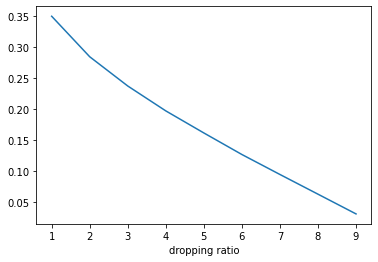

In [693]:
plt.plot( [9,8,7,6,5,4,3,2,1], [np.mean( (i!=Xte)[Xte_missing<0] ) for i in ratio] )
plt.xlabel("dropping ratio")
plt.show()

We could probably improve this a bit if we used the mean estimate, by saving the *average* of the Xhat values over the Gibbs sampling procedure.

In [525]:
def train_and_test(n_components, learning_rate, batch_size, n_iter):
    best_rbm = BernoulliRBM(verbose=0, random_state=0)
    greedy = 1000
    rbm = BernoulliRBM(n_components=n_components, learning_rate=learning_rate, batch_size=batch_size, n_iter=n_iter, verbose=0, random_state=0)
    rbm.fit(Xtr)
    Xte_hat1 = sample_missing(rbm,Xte_missing, nIter=100)
    temp_greedy = metrics.mean_squared_error(Xte.reshape(-1,1),Xte_hat1.reshape(-1,1))
    if temp_greedy < greedy:
        best_rbm = rbm
        greedy = temp_greedy 
    mse_hist.append(temp_greedy)
    return best_rbm

In [526]:
rbm_hist = []
mse_hist = []
best_rbm = BernoulliRBM(verbose=0, random_state=0)
from tqdm import trange
for nIter in trange(200):
    train_and_test(16, 0.001, 10, nIter+ 1)

100%|██████████| 200/200 [18:14<00:00,  5.47s/it]


In [527]:
best_rbm

BernoulliRBM(random_state=0)

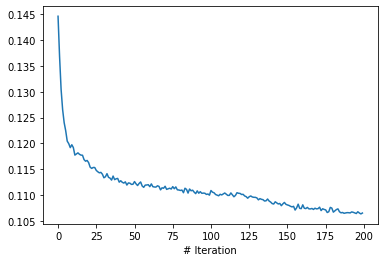

In [528]:
plt.plot(range(200),mse_hist)
plt.xlabel("# Iteration")
plt.show()

In [ ]:
from tqdm import trange
for nIter in trange(11):
    train_and_test(2**nIter, 0.001, 10, 10)

In [479]:
best_rbm

BernoulliRBM(learning_rate=0.01, n_components=512, n_iter=200, random_state=0)

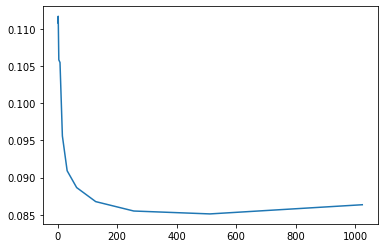

In [489]:
plt.plot([2**n for n in range(11)],mse_hist)
plt.xlabel("n_components")
plt.show()

In [495]:
np.mean(BernoulliRBM(learning_rate=0.01, n_components=1024, n_iter=200, random_state=0).fit(Xtr).score_samples(Xte))

-250.76819731831986

In [496]:
np.mean(BernoulliRBM(learning_rate=0.01, n_components=512, n_iter=200, random_state=0).fit(Xtr).score_samples(Xte))

-241.74383395452207

In [ ]:
from tqdm import trange
for nIter in trange(200):
    train_and_test(512, 0.001 + 0.001*nIter, 10, 10)

In [499]:
best_rbm

BernoulliRBM(learning_rate=0.2, n_components=512, random_state=0)

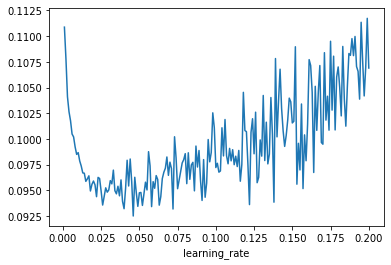

In [503]:
plt.plot([0.001 + 0.001*nIter for nIter in range(200)],mse_hist)
plt.xlabel("learning_rate")
plt.show()

In [506]:
np.mean(best_rbm.fit(Xtr).score_samples(Xte))

-270.97961961083513

In [529]:
rbm_hist = []
mse_hist = []
best_rbm = BernoulliRBM(verbose=0, random_state=0)
from tqdm import trange
for nIter in trange(100):
    
    a = train_and_test(16, 0.001, nIter+ 1, 10)

100%|██████████| 100/100 [02:32<00:00,  1.52s/it]


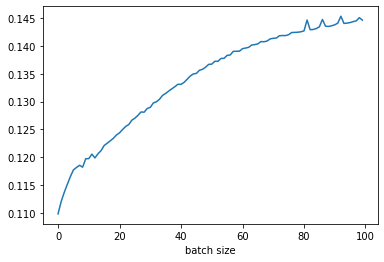

In [531]:
plt.plot(range(100),mse_hist)
plt.xlabel("batch size")
plt.show()

In [ ]:
rbm_hist = []
mse_hist = []
best_rbm = BernoulliRBM(verbose=0, random_state=0)
from tqdm import trange
for nIter in trange(100):
    for i in range(5):
        for i in range()
            a = train_and_test(16, 0.001, nIter+ 1, 10)